In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import preprocessing libraries
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Import Model
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
import xgboost as xgb
from sklearn.pipeline import Pipeline

# Import evaluation metric libraries
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

# Import model selection libraries
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# Import tree for visualization
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [3]:
# Path to your CSV file
file_path="Data/TRAIN.csv"
# Read the CSV file
data = pd.read_csv(file_path)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             188340 non-null  object 
 1   Store_id       188340 non-null  int64  
 2   Store_Type     188340 non-null  object 
 3   Location_Type  188340 non-null  object 
 4   Region_Code    188340 non-null  object 
 5   Date           188340 non-null  object 
 6   Holiday        188340 non-null  int64  
 7   Discount       188340 non-null  object 
 8   #Order         188340 non-null  int64  
 9   Sales          188340 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 14.4+ MB


In [ ]:
data.drop(['ID'], axis=1, inplace=True)

# 1. Data Preprocessing

**Data Consistency : Ensuring all dates are in the format YYYY-MM-DD**

In [5]:
#converting the date column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

#adding date features
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['WeekDay'] = data['Date'].dt.dayofweek
data['Is_weekend'] = data['WeekDay'].apply(lambda x: 1 if x >= 5 else 0)

**One Hot Encoding and Scaling**

In [20]:

# Define preprocessing for numerical and categorical features
numerical_features = ['Store_id','Discount','WeekDay', 'Is_weekend', 'Year', 'Day', 'Month', 'Holiday']
categorical_features = ['Store_Type', 'Location_Type','Region_Code']

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore') 

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [100]:
#Convert string to int
data['Discount'] = data['Discount'].map({'Yes': 1, 'No': 0})

**Handling Outliers**

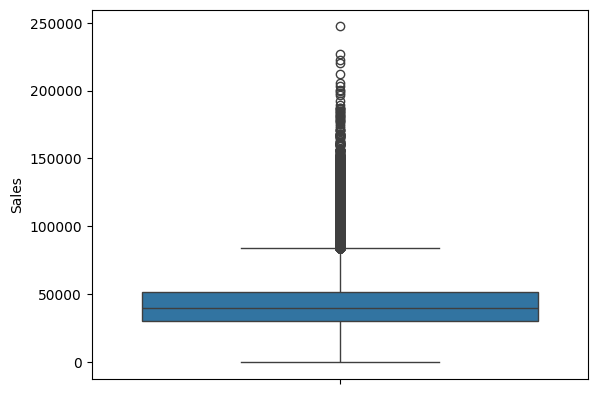

In [9]:
# Visualize the distribution of sales data
sns.boxplot(data['Sales'])
plt.show()

*Clipping values below the 1st percentile and above the 99th percentile ensures that extreme values are capped while retaining most of the data.*

In [10]:
# Calculate the 1st and 99th percentiles
lower_bound = data['Sales'].quantile(0.01)  # 1st percentile
upper_bound = data['Sales'].quantile(0.99)  # 99th percentile

print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")

Lower bound: 7081.680000000001, Upper bound: 102159.0


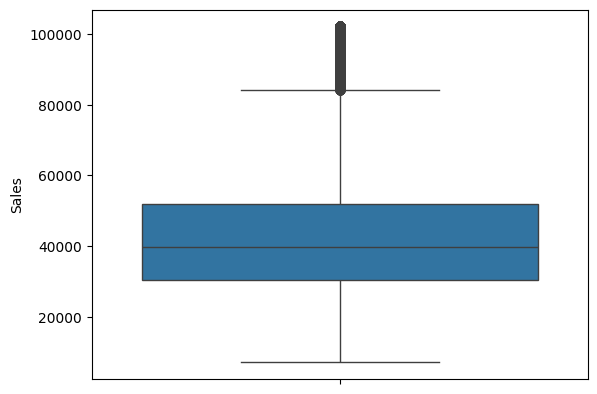

In [11]:
# Clip the data to the 1st and 99th percentiles
data['Sales'] = data['Sales'].clip(lower=lower_bound, upper=upper_bound)

sns.boxplot(data['Sales'])
plt.show()

# 2. Data Transformation

In [12]:
data_sales = data.copy()

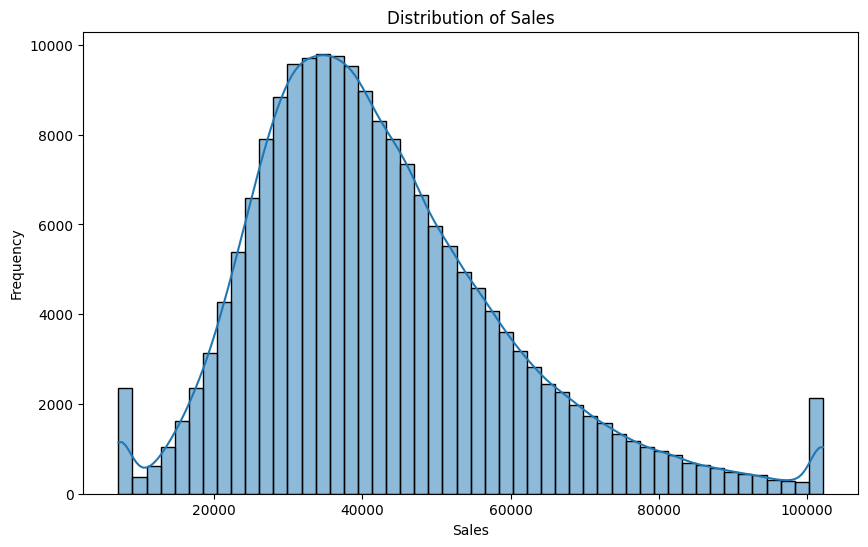

In [13]:
#Analysing Numerical Feature: Sales
plt.figure(figsize=(10,6))
sns.histplot(data_sales['Sales'], kde=True, bins=50)
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

In [14]:
# Skew of the dependent variable
data_sales['Sales'].skew()

np.float64(0.9029736123362417)

 * Square Root Transformation
 
    The Sales distribution appears to be rightly skewed. Since, most of the statistical tests and algorithms requires the data to be normally distributed. So, we will use square root transformation to transform the data.

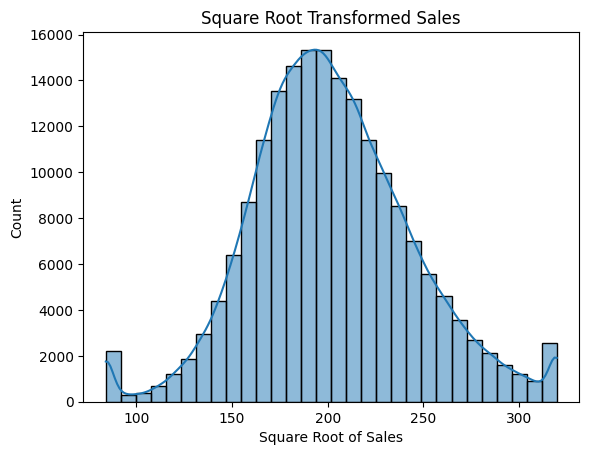

In [15]:
#Apply squre root transformation on sales
data_sales['sqrt_sales'] = data_sales['Sales'].apply(lambda x: np.sqrt(x))
sns.histplot(data_sales['sqrt_sales'], bins=30, kde=True)
plt.title('Square Root Transformed Sales')
plt.xlabel('Square Root of Sales')
plt.ylabel('Count')
plt.show()

Insights:
The plot we get post square root transformation looks like normally distributed and the right skewness reduced.

# 3. Feature Selection

In [16]:
# Remove multicollinearity by using VIF technique
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)


In [21]:
vif_results = calc_vif( data_sales[numerical_features])
print(vif_results)

    variables        VIF
0    Store_id   4.016485
1    Discount   1.822652
2     WeekDay   8.598917
3  Is_weekend   3.698328
4        Year  13.961440
5         Day   4.219800
6       Month   3.617094
7     Holiday   1.153801


High VIF values: WeekDay and Year have VIFs higher than 5, with Year being particularly concerning. These variables are likely to be highly correlated with other variables, potentially causing issues with regression analysis.

Moderate VIF values: Variables like Store_id, Discount, Is_weekend, Day, and Month have moderate VIFs (all < 5), indicating that while some correlation exists, it is not strong enough to cause significant issues.

Low VIF value: Holiday has the lowest VIF, meaning it is not correlated with other variables and poses no risk of multicollinearity

In [23]:
vif_results = calc_vif( data_sales[numerical_features])
print(vif_results)

  variables       VIF
0  Store_id  2.768847
1  Discount  1.664473
2   WeekDay  2.513541
3     Month  2.681020
4   Holiday  1.142474


# 4. Data Splitting

In [25]:
# Sort the dataset by the 'Date' column
data_sales_sorted = data_sales.sort_values(by='Date')

# Define the split ratio (e.g., 80% training, 20% testing)
split_ratio = 0.8
split_index = int(len(data_sales_sorted) * split_ratio)

# Split the data into training and testing sets
train_data = data_sales_sorted.iloc[:split_index]
test_data = data_sales_sorted.iloc[split_index:]

# Separate features (X) and target (y) for training and testing sets
X_train = train_data[['Store_id','Store_Type', 'Location_Type', 'Region_Code', 'Holiday', 'Discount', 'Year', 'Month', 'Day', 'WeekDay', 'Is_weekend']]
y_train = train_data['sqrt_sales']

X_test = test_data[['Store_id','Store_Type', 'Location_Type', 'Region_Code', 'Holiday', 'Discount', 'Year', 'Month', 'Day', 'WeekDay', 'Is_weekend']]
y_test = test_data['sqrt_sales']

# 5. ML Model Implementation

In [27]:
# Defining a function to print evaluation matrix
def evaluate_model(model, y_test, y_pred):

  '''takes model, y test and y pred values to print evaluation metrics, plot the actual and predicted values,
   and returns a list of the model scores'''

  # Calculating Evaluation Matrix
  mse = mean_squared_error(y_test,y_pred)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_test,y_pred)
  y_train_pred = model.predict(X_train)  # Predict the target variable for the training set
  r2_train = r2_score(y_train, y_train_pred)
  r2 = r2_score(y_test,y_pred)
  r2_adjusted = 1-(1-r2)*((len(X_test)-1)/(len(X_test)-X_test.shape[1]-1))

  # Printing Evaluation Matrix
  print("MSE :" , mse)
  print("RMSE :" ,rmse)
  print("MAE :" ,mae)
  print("Train R2 :" ,r2_train)
  print("Test R2 :" ,r2)
  print("Adjusted R2 : ", r2_adjusted)


  # plot actual and predicted values
  plt.figure(figsize=(12,4))
  plt.plot((y_pred)[:100])
  plt.plot((np.array(y_test)[:100]))
  plt.legend(["Predicted","Actual"])
  plt.title('Actual and Predicted Sales', fontsize=12)


  model_score = [mse,rmse,mae,r2_train,r2,r2_adjusted]
  return model_score

In [28]:
# Create a score dataframe
score = pd.DataFrame(index = ['MSE', 'RMSE', 'MAE', 'Train R2', 'Test R2', 'Adjusted R2'])

1. ML Model -Linear Regression

In [29]:
# Import the LinearRegression class
reg_model = LinearRegression()

# Create the pipeline
pipeline_reg = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', reg_model)])

# Fit the linear regression model to the training data
pipeline_reg.fit(X_train, y_train)

# Predict on the model
y_pred_L1 = pipeline_reg.predict(X_test)

MSE : 835.7153766143609
RMSE : 28.908742217785278
MAE : 21.483749861595975
Train R2 : 0.6016639664478499
Test R2 : 0.559867989226312
Adjusted R2 :  0.5597394186899165


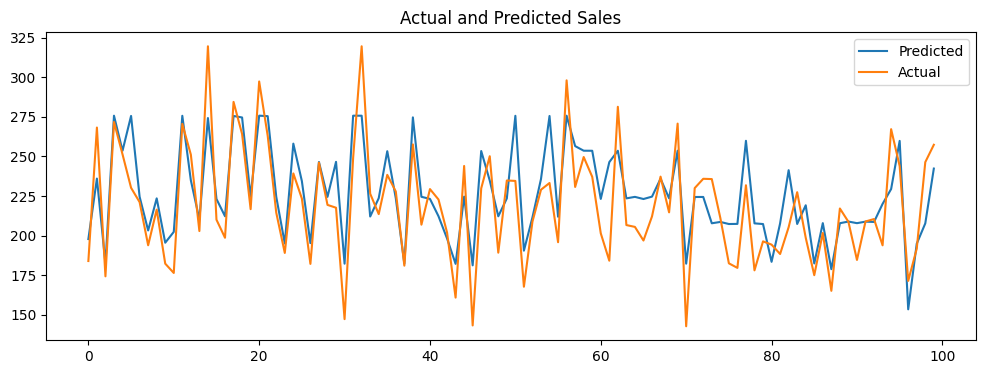

In [30]:
# Visualizing evaluation Metric Score chart
linear_score = evaluate_model(pipeline_reg, y_test,y_pred_L1)
score['Linear regression'] = linear_score

In [31]:
score

,Linear regression
MSE,835.715377
RMSE,28.908742
MAE,21.483750
Train R2,0.601664
Test R2,0.559868
Adjusted R2,0.559739


Hypertuning Linear Regression

In [32]:
reg = LinearRegression()

# Create the pipeline
pipeline_reg_tune = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', reg)])
# Define the parameters to be optimized
param_grid = {'regressor__fit_intercept': [True, False]}

# Perform grid search
grid_search = GridSearchCV(pipeline_reg_tune, param_grid, cv=5, scoring='r2', return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Store_id',
                                                                          'Discount',
                                                                          'WeekDay',
                                                                          'Month',
                                                                          'Holiday']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Store_Type',
                                                                          'Location_Type',
                                                                          'Region_Code'])])),
                                       ('regressor', LinearRegression())]),
             param_grid={'regressor__fit_intercept': [True, False]},
             return_train_score=True, scoring='r2')

MSE : 835.7153766143609
RMSE : 28.908742217785278
MAE : 21.483749861595975
Train R2 : 0.6016639664478499
Test R2 : 0.559867989226312
Adjusted R2 :  0.5597394186899165


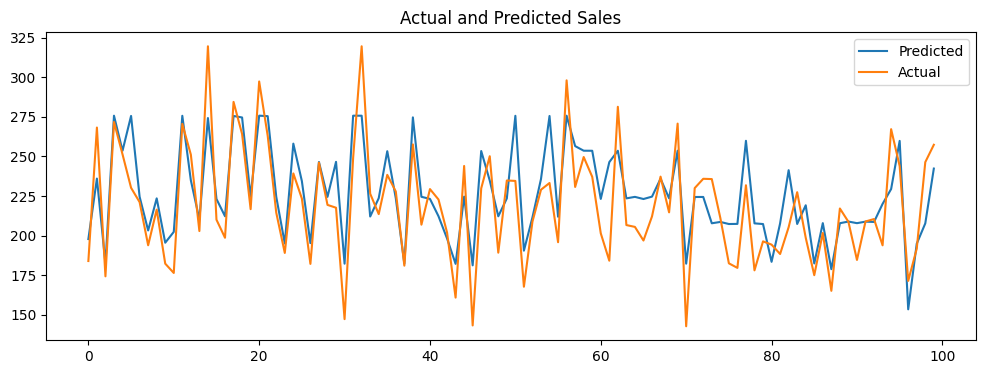

In [33]:
# Use the best parameter to train the model
best_reg = grid_search.best_estimator_
best_reg.fit(X_train, y_train)
# Predict on test data
y_pred_li2 = best_reg.predict(X_test)
# Visualizing evaluation Metric Score chart
linear_score2 = evaluate_model(best_reg, y_test,y_pred_li2)

In [34]:
# Updated Evaluation Metric Score chart
score['Linear regression tuned'] = linear_score2
score

,Linear regression,Linear regression tuned
MSE,835.715377,835.715377
RMSE,28.908742,28.908742
MAE,21.483750,21.483750
Train R2,0.601664,0.601664
Test R2,0.559868,0.559868
Adjusted R2,0.559739,0.559739


2. ML Model: Lasso Regression

In [35]:
# Import the Lasso Regression class
lasso = Lasso()

# Create the pipeline
pipeline_Lasso = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', lasso)])

# Fit the lasso regression model to the training data
pipeline_Lasso.fit(X_train, y_train)

# Predict on the model
y_pred_lasso1 = pipeline_Lasso.predict(X_test)

MSE : 871.2546070435752
RMSE : 29.517022326846845
MAE : 21.902707474474493
Train R2 : 0.5799960841328942
Test R2 : 0.5411511468803831
Adjusted R2 :  0.5410171088151527


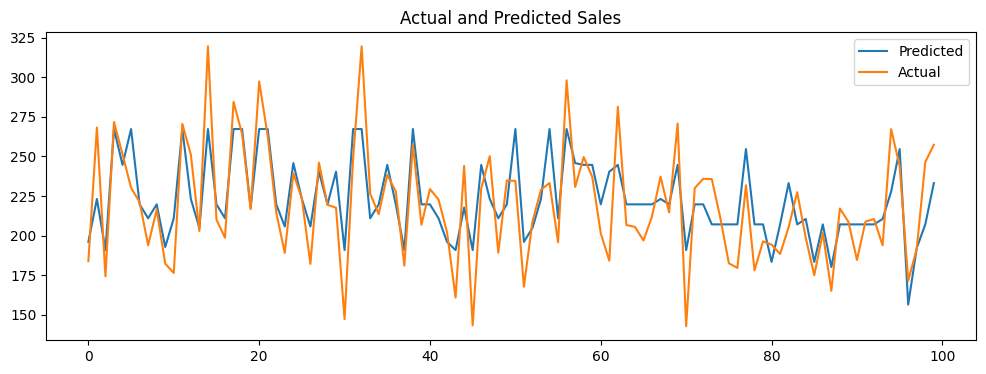

In [36]:
# Visualizing evaluation Metric Score chart
lasso_score = evaluate_model(pipeline_Lasso, y_test,y_pred_lasso1)
score['Lasso regression'] = lasso_score

In [37]:
# Updated Evaluation Metric Score chart
score

,Linear regression,Linear regression tuned,Lasso regression
MSE,835.715377,835.715377,871.254607
RMSE,28.908742,28.908742,29.517022
MAE,21.483750,21.483750,21.902707
Train R2,0.601664,0.601664,0.579996
Test R2,0.559868,0.559868,0.541151
Adjusted R2,0.559739,0.559739,0.541017


HyperParameter Tuning Lasso Regression 

In [38]:
# Define the model
lasso = Lasso()
# Create the pipeline
pipeline_lasso_tune = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', lasso)])
# Define the range of alpha values to test
alphas = np.logspace(-4, 1, 50)
parameters = {'regressor__alpha': alphas}
lasso_regressor = GridSearchCV(pipeline_lasso_tune, parameters, scoring='neg_mean_squared_error', cv=5)

# Fitting model
lasso_regressor.fit(X_train,y_train)

/Users/lavanyamullachery/Desktop/GIT/Product_SalesForecasting_PP/pp_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.188e+06, tolerance: 2.154e+04
  model = cd_fast.enet_coordinate_descent(
/Users/lavanyamullachery/Desktop/GIT/Product_SalesForecasting_PP/pp_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.844e+06, tolerance: 2.210e+04
  model = cd_fast.enet_coordinate_descent(
/Users/lavanyamullachery/Desktop/GIT/Product_SalesForecasting_PP/pp_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Store_id',
                                                                          'Discount',
                                                                          'WeekDay',
                                                                          'Month',
                                                                          'Holiday']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Store_Type',
                                                                          'Location_Type',
                                                                          'Region_Code'])])),
                                       ('regressor', Lasso())]),
             param_grid={'regressor__alpha': array([1.00000000e-04, 1.2648552...
       7.19685673e-02, 9.10298178e-02, 1.15139540e-01, 1.45634848e-01,
       1.84206997e-01, 2.32995181e-01, 2.94705170e-01, 3.72759372e-01,
       4.71486636e-01, 5.96362332e-01, 7.54312006e-01, 9.54095476e-01,
       1.20679264e+00, 1.52641797e+00, 1.93069773e+00, 2.44205309e+00,
       3.08884360e+00, 3.90693994e+00, 4.94171336e+00, 6.25055193e+00,
       7.90604321e+00, 1.00000000e+01])},
             scoring='neg_mean_squared_error')

In [39]:
# Import the Lasso Regression class with best alpha
lasso = Lasso(alpha = lasso_regressor.best_params_['regressor__alpha'])
# Create the pipeline
pipeline_lasso_tune = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', lasso)])

# Fit the lasso regression model to your training data
pipeline_lasso_tune.fit(X_train, y_train)

# Predict the model
y_pred_lassocv = pipeline_lasso_tune.predict(X_test)

MSE : 835.851366747095
RMSE : 28.911094181076837
MAE : 21.471638304661347
Train R2 : 0.6014558554530396
Test R2 : 0.5597963696148505
Adjusted R2 :  0.5596677781570686


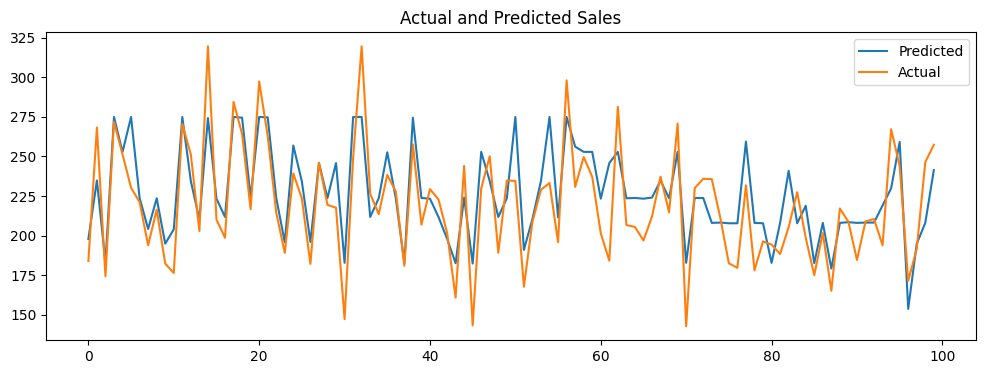

In [40]:
#Evaluation matrices for Lasso regression
lasso2 = evaluate_model(pipeline_lasso_tune, y_test,y_pred_lassocv)

name = 'Lasso with alpha = ' + str(lasso_regressor.best_params_['regressor__alpha'])

score[name] = lasso2

In [41]:
# Updated Evaluation Metric Score chart
score

,Linear regression,Linear regression tuned,Lasso regression,Lasso with alpha = 0.07196856730011521
MSE,835.715377,835.715377,871.254607,835.851367
RMSE,28.908742,28.908742,29.517022,28.911094
MAE,21.483750,21.483750,21.902707,21.471638
Train R2,0.601664,0.601664,0.579996,0.601456
Test R2,0.559868,0.559868,0.541151,0.559796
Adjusted R2,0.559739,0.559739,0.541017,0.559668


3. ML Model: Ridge Regression

In [42]:
# Ridge regressor class
ridge = Ridge()

pipeline_ridge = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', ridge)])
# Fit the ridge regression model to your training data
pipeline_ridge.fit(X_train, y_train)

# Predict on the model
y_pred_ridge1 = pipeline_ridge.predict(X_test)

MSE : 835.7153117501867
RMSE : 28.90874109590708
MAE : 21.48373050624387
Train R2 : 0.6016639661116899
Test R2 : 0.559868023387224
Adjusted R2 :  0.5597394528608075


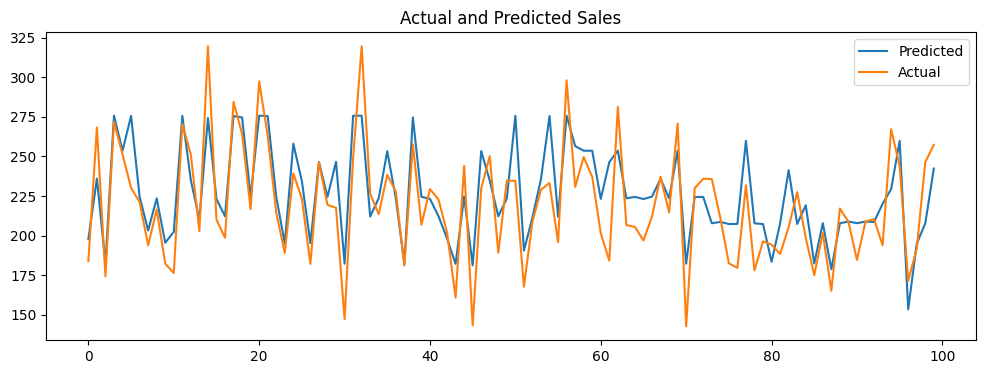

In [43]:
# Visualizing evaluation Metric Score chart
result = evaluate_model(pipeline_ridge, y_test,y_pred_ridge1)
score['Ridge'] = result

In [44]:
# Updated Evaluation Metric Score chart
score

,Linear regression,Linear regression tuned,Lasso regression,Lasso with alpha = 0.07196856730011521,Ridge
MSE,835.715377,835.715377,871.254607,835.851367,835.715312
RMSE,28.908742,28.908742,29.517022,28.911094,28.908741
MAE,21.483750,21.483750,21.902707,21.471638,21.483731
Train R2,0.601664,0.601664,0.579996,0.601456,0.601664
Test R2,0.559868,0.559868,0.541151,0.559796,0.559868
Adjusted R2,0.559739,0.559739,0.541017,0.559668,0.559739


HyperParameter Tuning Ridge Regression

In [45]:
# Import Ridge regressor Class
ridge = Ridge()
pipeline_rdige_tune= Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', ridge)])

# Define the parameters to be optimized & Perform grid search
parameters = {'regressor__alpha': [1e-15,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1,5,10,20,30,40,45,50,55,60,100]}
ridge_regressor = GridSearchCV(pipeline_rdige_tune, parameters, scoring='neg_mean_squared_error', cv=5)

# Fitting model
ridge_regressor.fit(X_train,y_train)

/Users/lavanyamullachery/Desktop/GIT/Product_SalesForecasting_PP/pp_env/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=3.98219e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Store_id',
                                                                          'Discount',
                                                                          'WeekDay',
                                                                          'Month',
                                                                          'Holiday']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Store_Type',
                                                                          'Location_Type',
                                                                          'Region_Code'])])),
                                       ('regressor', Ridge())]),
             param_grid={'regressor__alpha': [1e-15, 1e-10, 1e-08, 1e-05,
                                              0.0001, 0.001, 0.01, 1, 5, 10, 20,
                                              30, 40, 45, 50, 55, 60, 100]},
             scoring='neg_mean_squared_error')

In [46]:
# Initiate ridge with best alpha
ridge = Ridge(alpha = ridge_regressor.best_params_['regressor__alpha'])
pipeline_ridge_tune = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', ridge)])

# Fit the ridge regression model to your training data
pipeline_ridge_tune.fit(X_train, y_train)

# Predict on model
y_pred_ridge = pipeline_ridge_tune.predict(X_test)

MSE : 835.7147909962956
RMSE : 28.908732089047
MAE : 21.483557663864527
Train R2 : 0.6016639328725784
Test R2 : 0.5598682976438234
Adjusted R2 :  0.5597397271975222


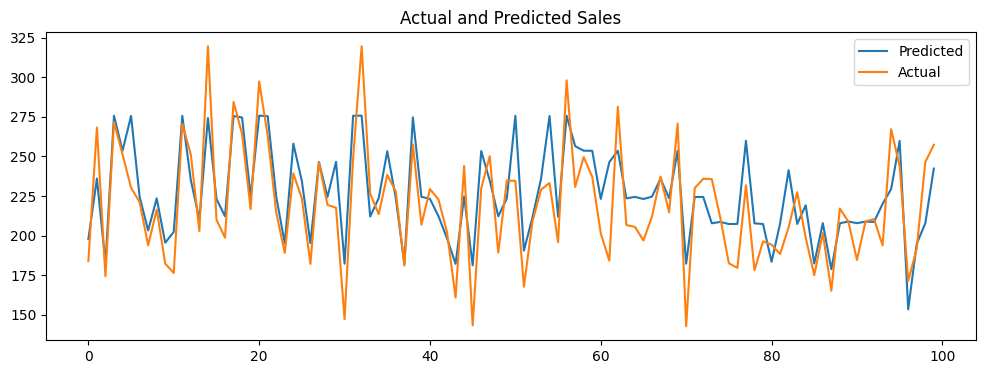

In [47]:
# Evaluation matrices for Ridge regression
result = evaluate_model(pipeline_ridge_tune, y_test,y_pred_ridge)

namer = 'Ridge with alpha = ' + str(ridge_regressor.best_params_['regressor__alpha'])

score[namer] = result

In [48]:
# Updated Evaluation Metric Score chart
score

,Linear regression,Linear regression tuned,Lasso regression,Lasso with alpha = 0.07196856730011521,Ridge,Ridge with alpha = 10
MSE,835.715377,835.715377,871.254607,835.851367,835.715312,835.714791
RMSE,28.908742,28.908742,29.517022,28.911094,28.908741,28.908732
MAE,21.483750,21.483750,21.902707,21.471638,21.483731,21.483558
Train R2,0.601664,0.601664,0.579996,0.601456,0.601664,0.601664
Test R2,0.559868,0.559868,0.541151,0.559796,0.559868,0.559868
Adjusted R2,0.559739,0.559739,0.541017,0.559668,0.559739,0.559740


**Interpretation**

*Linear Regression Models:*

* Standard and tuned linear regression models perform similarly, with an MSE of 835.72 and Test R² of 0.5599.

* Lasso regression has a slightly higher error (MSE = 871.25), likely due to feature selection effects.

* Ridge regression performs similarly to standard linear regression.

4. ML Model: Decision Tree Regressor

In [49]:
# Import Decision Tree Regressor class
dt = DecisionTreeRegressor(random_state=1)
pipeline_dt = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', dt)])

# Fit the Decision Tree model to your training data
pipeline_dt.fit(X_train,y_train)

# Predict on the model
y_pred_dt1 = pipeline_dt.predict(X_test)

MSE : 914.7437030034868
RMSE : 30.244730169130072
MAE : 21.76348639290547
Train R2 : 0.8719310475310555
Test R2 : 0.51824748399804
Adjusted R2 :  0.5181067553578227


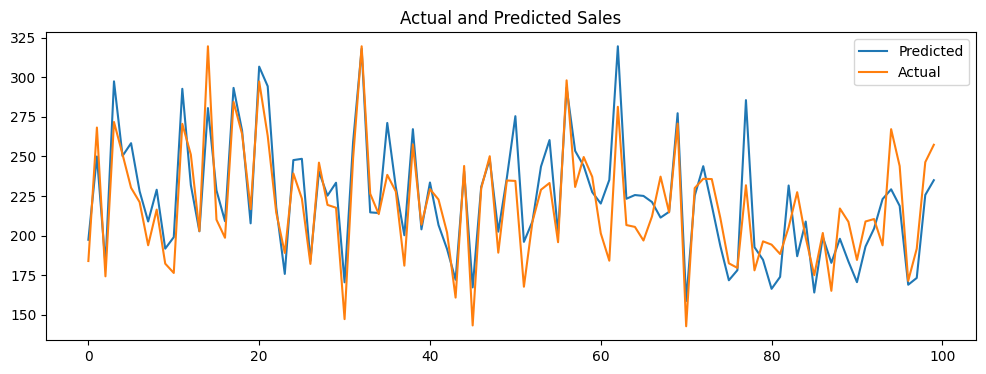

In [50]:
# Visualizing evaluation Metric Score chart
result = evaluate_model(pipeline_dt, y_test,y_pred_dt1)
score['Decision tree'] = result

In [51]:
# Updated Evaluation Metric Score chart
score

,Linear regression,Linear regression tuned,Lasso regression,Lasso with alpha = 0.07196856730011521,Ridge,Ridge with alpha = 10,Decision tree
MSE,835.715377,835.715377,871.254607,835.851367,835.715312,835.714791,914.743703
RMSE,28.908742,28.908742,29.517022,28.911094,28.908741,28.908732,30.244730
MAE,21.483750,21.483750,21.902707,21.471638,21.483731,21.483558,21.763486
Train R2,0.601664,0.601664,0.579996,0.601456,0.601664,0.601664,0.871931
Test R2,0.559868,0.559868,0.541151,0.559796,0.559868,0.559868,0.518247
Adjusted R2,0.559739,0.559739,0.541017,0.559668,0.559739,0.559740,0.518107


HyperParameter Tuning DT Regressor

In [53]:
# DT Regressor
dt_model = DecisionTreeRegressor(random_state=1)
pipeline_dt_tune = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', dt_model)])

# Define the hyperparameter grid
grid = {
    'regressor__max_depth': [6, 8, 10],
    'regressor__min_samples_split': np.arange(40, 60),
    'regressor__min_samples_leaf': np.arange(10, 20)
}

# Fitting model with hypertuned paramaters using grid search
dt_gridsearch = GridSearchCV(pipeline_dt_tune,
                             grid,
                             cv=6,
                             scoring= 'neg_root_mean_squared_error')
dt_gridsearch.fit(X_train,y_train)
dt_best_params = dt_gridsearch.best_params_

In [54]:
dt_best_params 

{'regressor__max_depth': 8,
 'regressor__min_samples_leaf': np.int64(10),
 'regressor__min_samples_split': np.int64(56)}

In [55]:
# Building Decision Tree model with best parameters
dt_model = DecisionTreeRegressor(max_depth=dt_best_params['regressor__max_depth'],
                                 min_samples_leaf=dt_best_params['regressor__min_samples_leaf'],
                                 min_samples_split=dt_best_params['regressor__min_samples_split'],
                                 random_state=1)


pipeline_dt_tune = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', dt_model)])
# Fitting model
pipeline_dt_tune.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Store_id', 'Discount',
                                                   'WeekDay', 'Month',
                                                   'Holiday']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Store_Type',
                                                   'Location_Type',
                                                   'Region_Code'])])),
                ('regressor',
                 DecisionTreeRegressor(max_depth=8,
                                       min_samples_leaf=np.int64(10),
                                       min_samples_split=np.int64(56),
                                       random_state=1))])

In [56]:
# Predict on the model
y_pred_dt2 = pipeline_dt_tune.predict(X_test)

MSE : 801.589235828578
RMSE : 28.312351294595402
MAE : 20.981164270135718
Train R2 : 0.6839276133232504
Test R2 : 0.5778406236713565
Adjusted R2 :  0.5777173032671814


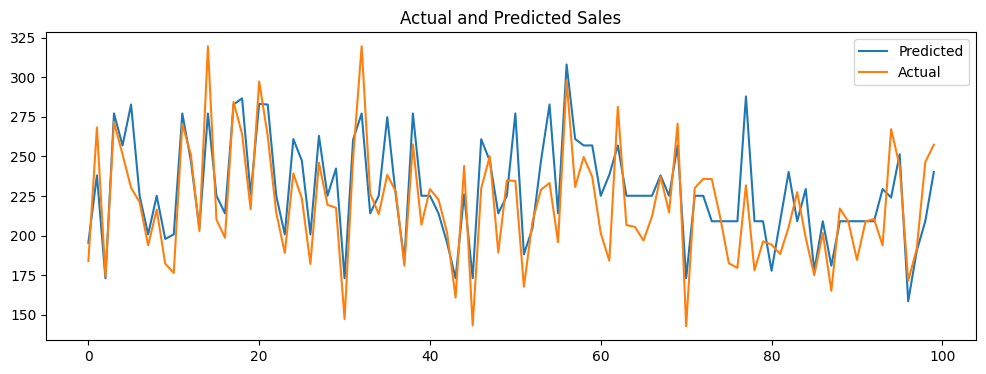

In [57]:
# Evaluation matrices for DecisionTree
result = evaluate_model(pipeline_dt_tune, y_test,y_pred_dt2)
score['Decision tree tuned'] = result

In [58]:
# Updated Evaluation Metric Score chart
score

,Linear regression,Linear regression tuned,Lasso regression,Lasso with alpha = 0.07196856730011521,Ridge,Ridge with alpha = 10,Decision tree,Decision tree tuned
MSE,835.715377,835.715377,871.254607,835.851367,835.715312,835.714791,914.743703,801.589236
RMSE,28.908742,28.908742,29.517022,28.911094,28.908741,28.908732,30.244730,28.312351
MAE,21.483750,21.483750,21.902707,21.471638,21.483731,21.483558,21.763486,20.981164
Train R2,0.601664,0.601664,0.579996,0.601456,0.601664,0.601664,0.871931,0.683928
Test R2,0.559868,0.559868,0.541151,0.559796,0.559868,0.559868,0.518247,0.577841
Adjusted R2,0.559739,0.559739,0.541017,0.559668,0.559739,0.559740,0.518107,0.577717


**Interpretation**

*Decision Tree Models:*

* The untuned decision tree has high variance (Train R² = 0.8719, but Test R² = 0.5182), indicating overfitting.

* The tuned decision tree improves generalization, reducing MSE to 801.59 and improving Test R² to 0.5778.

5. ML Model: Random Forest

In [59]:
# Import Random Forest Regressor class
rf = RandomForestRegressor(random_state=1)
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', rf)])

# Fit the Decision Tree model to your training data
pipeline_rf.fit(X_train,y_train)

# Predict on the model
y_pred_rf = pipeline_rf.predict(X_test)

MSE : 857.0422989871064
RMSE : 29.27528478063205
MAE : 21.099357459614847
Train R2 : 0.8648584838862217
Test R2 : 0.5486361015643213
Adjusted R2 :  0.5485042499899961


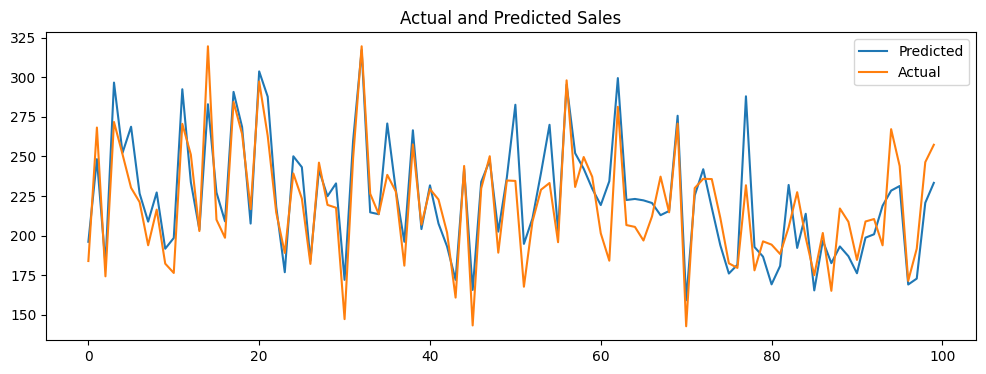

In [60]:
# Visualizing evaluation Metric Score chart
result = evaluate_model(pipeline_rf, y_test,y_pred_rf)
score['Random forest'] = result

In [61]:
# Updated Evaluation Metric Score chart
score

,Linear regression,Linear regression tuned,Lasso regression,Lasso with alpha = 0.07196856730011521,Ridge,Ridge with alpha = 10,Decision tree,Decision tree tuned,Random forest
MSE,835.715377,835.715377,871.254607,835.851367,835.715312,835.714791,914.743703,801.589236,857.042299
RMSE,28.908742,28.908742,29.517022,28.911094,28.908741,28.908732,30.244730,28.312351,29.275285
MAE,21.483750,21.483750,21.902707,21.471638,21.483731,21.483558,21.763486,20.981164,21.099357
Train R2,0.601664,0.601664,0.579996,0.601456,0.601664,0.601664,0.871931,0.683928,0.864858
Test R2,0.559868,0.559868,0.541151,0.559796,0.559868,0.559868,0.518247,0.577841,0.548636
Adjusted R2,0.559739,0.559739,0.541017,0.559668,0.559739,0.559740,0.518107,0.577717,0.548504


HyperParameter Tuning RandomForest

In [62]:
# RF Regressor
rf_model = RandomForestRegressor(random_state=1)
pipeline_rf_tune = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', rf_model)])
rf_params = {'regressor__n_estimators': [300],
    'regressor__max_depth': [1, 4, 8],              #Approximate from DT regressor
    'regressor__min_samples_split': [10,20], 
    'regressor__min_samples_leaf': np.arange(10,20)} 

In [63]:
# Fitting a Random Forest model with best parameters obtained from gridsearch
rf_gridsearch = GridSearchCV(pipeline_rf_tune,rf_params,cv=6,scoring='neg_root_mean_squared_error')
rf_gridsearch.fit(X_train,y_train)
rf_best_params = rf_gridsearch.best_params_

In [64]:
rf_best_params

{'regressor__max_depth': 8,
 'regressor__min_samples_leaf': np.int64(10),
 'regressor__min_samples_split': 10,
 'regressor__n_estimators': 300}

In [65]:
# Building Random Forest model with best parameters
rf_model = RandomForestRegressor(n_estimators=rf_best_params['regressor__n_estimators'],
                                 min_samples_leaf=rf_best_params['regressor__min_samples_leaf'],
                                 random_state=0)

pipeline_rf_tune = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', rf_model)])
# Fitting model
pipeline_rf_tune.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Store_id', 'Discount',
                                                   'WeekDay', 'Month',
                                                   'Holiday']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Store_Type',
                                                   'Location_Type',
                                                   'Region_Code'])])),
                ('regressor',
                 RandomForestRegressor(min_samples_leaf=np.int64(10),
                                       n_estimators=300, random_state=0))])

In [66]:
y_pred_rf1 = pipeline_rf_tune.predict(X_test)

MSE : 793.0598543697591
RMSE : 28.16131840610022
MAE : 20.19957225815224
Train R2 : 0.8033348868727613
Test R2 : 0.5823326480102339
Adjusted R2 :  0.5822106398077724


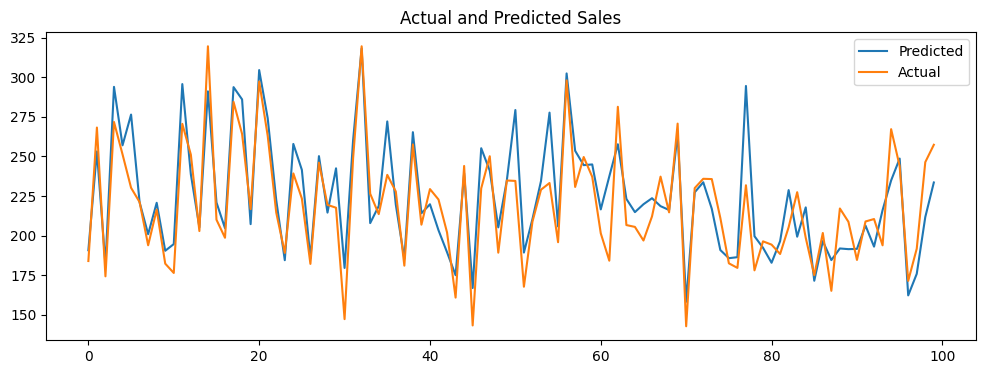

In [67]:
# Evaluation matrices for RandomForest
result = evaluate_model(pipeline_rf_tune, y_test,y_pred_rf1)
score['Random Forest tuned'] = result

In [68]:
# Updated Evaluation Metric Score chart
score

,Linear regression,Linear regression tuned,Lasso regression,Lasso with alpha = 0.07196856730011521,Ridge,Ridge with alpha = 10,Decision tree,Decision tree tuned,Random forest,Random Forest tuned
MSE,835.715377,835.715377,871.254607,835.851367,835.715312,835.714791,914.743703,801.589236,857.042299,793.059854
RMSE,28.908742,28.908742,29.517022,28.911094,28.908741,28.908732,30.244730,28.312351,29.275285,28.161318
MAE,21.483750,21.483750,21.902707,21.471638,21.483731,21.483558,21.763486,20.981164,21.099357,20.199572
Train R2,0.601664,0.601664,0.579996,0.601456,0.601664,0.601664,0.871931,0.683928,0.864858,0.803335
Test R2,0.559868,0.559868,0.541151,0.559796,0.559868,0.559868,0.518247,0.577841,0.548636,0.582333
Adjusted R2,0.559739,0.559739,0.541017,0.559668,0.559739,0.559740,0.518107,0.577717,0.548504,0.582211


**Interpretation**

*Random Forest Models:*

* The untuned random forest model performs better than linear models but still has room for improvement (MSE = 857.04, Test R² = 0.5486).

* The tuned random forest significantly improves performance, reducing MSE to 793.06 and increasing Test R² to 0.5822.

6. ML Model: Gradient Boosting Regressor

In [69]:
# Import Gradient Boosting Regressor class
gb = GradientBoostingRegressor(random_state=1)

pipeline_gb = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', gb)])

# Fit the Gradient Boosting model to the training data
pipeline_gb.fit(X_train,y_train)

# Predict on the model
y_pred_gb = pipeline_gb.predict(X_test)

MSE : 740.3205941280551
RMSE : 27.208833016652058
MAE : 20.172231804202028
Train R2 : 0.6871451786623198
Test R2 : 0.6101079376679821
Adjusted R2 :  0.609994043130972


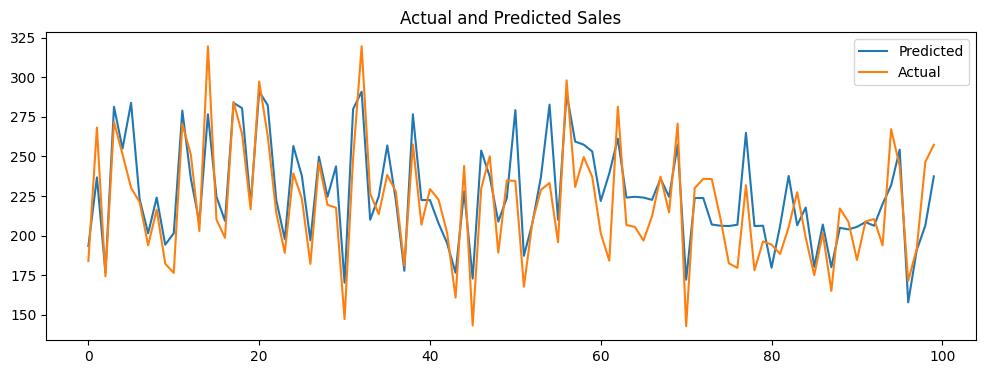

In [70]:
# Visualizing evaluation Metric Score chart
result = evaluate_model(pipeline_gb, y_test,y_pred_gb)
score['Gradient Boosting Regressor'] = result

In [71]:
# Updated Evaluation Metric Score chart
score

,Linear regression,Linear regression tuned,Lasso regression,Lasso with alpha = 0.07196856730011521,Ridge,Ridge with alpha = 10,Decision tree,Decision tree tuned,Random forest,Random Forest tuned,Gradient Boosting Regressor
MSE,835.715377,835.715377,871.254607,835.851367,835.715312,835.714791,914.743703,801.589236,857.042299,793.059854,740.320594
RMSE,28.908742,28.908742,29.517022,28.911094,28.908741,28.908732,30.244730,28.312351,29.275285,28.161318,27.208833
MAE,21.483750,21.483750,21.902707,21.471638,21.483731,21.483558,21.763486,20.981164,21.099357,20.199572,20.172232
Train R2,0.601664,0.601664,0.579996,0.601456,0.601664,0.601664,0.871931,0.683928,0.864858,0.803335,0.687145
Test R2,0.559868,0.559868,0.541151,0.559796,0.559868,0.559868,0.518247,0.577841,0.548636,0.582333,0.610108
Adjusted R2,0.559739,0.559739,0.541017,0.559668,0.559739,0.559740,0.518107,0.577717,0.548504,0.582211,0.609994


HyperParameter Tuning GB

In [72]:
# Gradient Boosting Model
gb_model = GradientBoostingRegressor(random_state=1)
pipeline_gb_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', gb_model)])
gb_params = {'regressor__n_estimators':[300] ,
             'regressor__min_samples_leaf':np.arange(25, 35, 5),
             'regressor__max_depth':[1,3,5]
             }

In [73]:
# Perform the randomized search
random_search = RandomizedSearchCV(pipeline_gb_model, param_distributions=gb_params, cv=6, n_iter=20, scoring='neg_root_mean_squared_error', n_jobs=-1)
random_search.fit(X_train, y_train)

gb_best_params = random_search.best_params_

/Users/lavanyamullachery/Desktop/GIT/Product_SalesForecasting_PP/pp_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [74]:
gb_best_params

{'regressor__n_estimators': 300,
 'regressor__min_samples_leaf': np.int64(30),
 'regressor__max_depth': 3}

In [75]:
# Building Gradient Boosting Model with best parameters
gb_model_tune = GradientBoostingRegressor(n_estimators=gb_best_params['regressor__n_estimators'],
                                     min_samples_leaf=gb_best_params['regressor__min_samples_leaf'],
                                     max_depth = gb_best_params['regressor__max_depth'],
                                     random_state=0)


pipeline_gb_model_tune = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', gb_model_tune)])

# Fitting model
pipeline_gb_model_tune.fit(X_train,y_train)

# Predict on the Model
y_pred_gb = pipeline_gb_model_tune.predict(X_test)

MSE : 695.2400396222321
RMSE : 26.367404870829287
MAE : 19.384080722229466
Train R2 : 0.730288119969305
Test R2 : 0.6338497469689213
Adjusted R2 :  0.6337427878446558


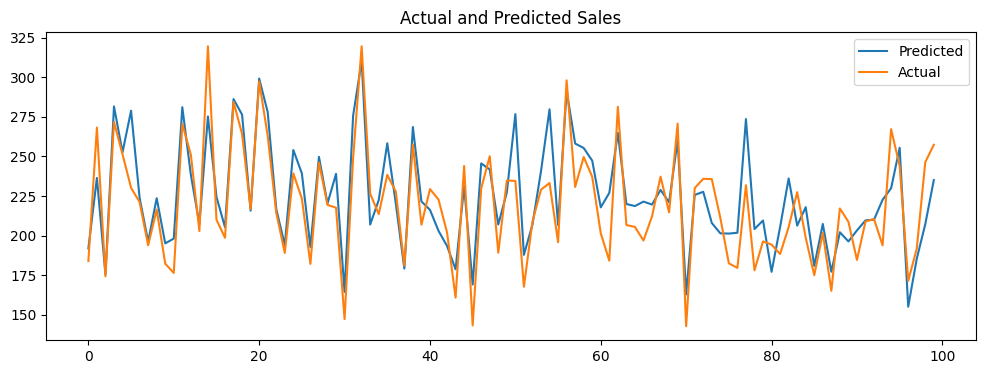

In [76]:
# Evaluation matrices for GradientBoosting
result = evaluate_model(pipeline_gb_model_tune, y_test,y_pred_gb)
score['Gradient Boosting Regressor Tuned'] = result

In [77]:
score

,Linear regression,Linear regression tuned,Lasso regression,Lasso with alpha = 0.07196856730011521,Ridge,Ridge with alpha = 10,Decision tree,Decision tree tuned,Random forest,Random Forest tuned,Gradient Boosting Regressor,Gradient Boosting Regressor Tuned
MSE,835.715377,835.715377,871.254607,835.851367,835.715312,835.714791,914.743703,801.589236,857.042299,793.059854,740.320594,695.240040
RMSE,28.908742,28.908742,29.517022,28.911094,28.908741,28.908732,30.244730,28.312351,29.275285,28.161318,27.208833,26.367405
MAE,21.483750,21.483750,21.902707,21.471638,21.483731,21.483558,21.763486,20.981164,21.099357,20.199572,20.172232,19.384081
Train R2,0.601664,0.601664,0.579996,0.601456,0.601664,0.601664,0.871931,0.683928,0.864858,0.803335,0.687145,0.730288
Test R2,0.559868,0.559868,0.541151,0.559796,0.559868,0.559868,0.518247,0.577841,0.548636,0.582333,0.610108,0.633850
Adjusted R2,0.559739,0.559739,0.541017,0.559668,0.559739,0.559740,0.518107,0.577717,0.548504,0.582211,0.609994,0.633743


**Interpretation:**

*Gradient Boosting Models:*

* Gradient Boosting outperforms all other models, achieving the lowest MSE (740.32) and highest Test R² (0.6101).

* The tuned version further improves these metrics, reducing MSE to 695.24 and achieving the best Test R² (0.6338).

In [78]:
score_T = score.transpose()
score_T

,MSE,RMSE,MAE,Train R2,Test R2,Adjusted R2
Linear regression,835.715377,28.908742,21.483750,0.601664,0.559868,0.559739
Linear regression tuned,835.715377,28.908742,21.483750,0.601664,0.559868,0.559739
Lasso regression,871.254607,29.517022,21.902707,0.579996,0.541151,0.541017
Lasso with alpha = 0.07196856730011521,835.851367,28.911094,21.471638,0.601456,0.559796,0.559668
Ridge,835.715312,28.908741,21.483731,0.601664,0.559868,0.559739
Ridge with alpha = 10,835.714791,28.908732,21.483558,0.601664,0.559868,0.559740
Decision tree,914.743703,30.244730,21.763486,0.871931,0.518247,0.518107
Decision tree tuned,801.589236,28.312351,20.981164,0.683928,0.577841,0.577717
Random forest,857.042299,29.275285,21.099357,0.864858,0.548636,0.548504
Random Forest tuned,793.059854,28.161318,20.199572,0.803335,0.582333,0.582211


Insights:

1. Gradient Boosting (Tuned) is the best-performing model, with the lowest error and highest predictive power.

2. Random Forest (Tuned) and Decision Tree (Tuned) also perform well, significantly improving over their untuned versions.

3. Linear regression models, including Ridge and Lasso, perform adequately but are outperformed by tree-based models.

4. Feature selection (Lasso) doesn't significantly improve performance, while Ridge regression provides no meaningful advantage over standard linear regression.

In [101]:
df = pd.DataFrame(score_T)
df

,MSE,RMSE,MAE,Train R2,Test R2,Adjusted R2
Linear regression,835.715377,28.908742,21.483750,0.601664,0.559868,0.559739
Linear regression tuned,835.715377,28.908742,21.483750,0.601664,0.559868,0.559739
Lasso regression,871.254607,29.517022,21.902707,0.579996,0.541151,0.541017
Lasso with alpha = 0.07196856730011521,835.851367,28.911094,21.471638,0.601456,0.559796,0.559668
Ridge,835.715312,28.908741,21.483731,0.601664,0.559868,0.559739
Ridge with alpha = 10,835.714791,28.908732,21.483558,0.601664,0.559868,0.559740
Decision tree,914.743703,30.244730,21.763486,0.871931,0.518247,0.518107
Decision tree tuned,801.589236,28.312351,20.981164,0.683928,0.577841,0.577717
Random forest,857.042299,29.275285,21.099357,0.864858,0.548636,0.548504
Random Forest tuned,793.059854,28.161318,20.199572,0.803335,0.582333,0.582211


In [80]:
def select_best_model(df, metrics):

    best_models = {}
    for metric in metrics:
        max_test = df['Test ' + metric].max()
        best_model_test = df[df['Test ' + metric] == max_test].index[0]
        best_model = best_model_test
        best_models[metric] = best_model
    return best_models

In [81]:
metrics = ['R2']

best_model = select_best_model(df, metrics)
print("The best model is:")
for metric, best_model in best_model.items():
    print(f"{metric}: {best_model} : {df['Test '+metric][best_model].round(4)}")

The best model is:
R2: Gradient Boosting Regressor Tuned : 0.6338


I have ran a several models like linear regression, decision tree, random forest, and  gradient boosting but amongst them I have selected Gradient Boosting tuned model as I achieved 73% training accuracy and 63% testing accuracy.

But neither of the models are very good models. All the models have 26–28% error. R² score is also less than 0.65. This shows that our model won't give very good results. But still, our models have moderate predictive accuracy. The models are not highly accurate but still usable for making general predictions.


**Conclusion:

Hyper-Tuned Gradient Boosting is the Best Performing Model So Far**

* Highest Test R² (0.634) among all models → Best generalization.

* Lowest MSE & RMSE → Most accurate predictions.

* Lower MAE → Fewer absolute errors in predictions.

* Balanced model → No significant overfitting while improving overall performance.

*1. Save the best performing ML model in a pickle file format for deployment process.*

In [84]:
pipeline_gb_model_tune = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', GradientBoostingRegressor(n_estimators=gb_best_params['regressor__n_estimators'],
                                     min_samples_leaf=gb_best_params['regressor__min_samples_leaf'],
                                     max_depth = gb_best_params['regressor__max_depth'],
                                     random_state=0))])

# Fit the model
pipeline_gb_model_tune.fit(X_train, y_train)

import pickle
# Save the model to a pickle file
with open("gradient_boosting_regression_model_tuned.pkl", "wb") as f:
    pickle.dump(pipeline_gb_model_tune, f)

*2. Again Load the saved model file and try to predict unseen data for a sanity check.*

In [86]:
# Load the model from the pickle file
with open("gradient_boosting_regression_model_tuned.pkl", "rb") as f:
    loaded_gb_model = pickle.load(f)

# Make predictions using the loaded model
new_test_preds = loaded_gb_model.predict(X_test)

# Sanity Check
mse = mean_squared_error(y_test, new_test_preds)
mae = mean_absolute_error(y_test, new_test_preds)
r2 = r2_score(y_test, new_test_preds)

print("MSE:", mse)
print("MAE:", mae)
print("R² Score:", r2)

MSE: 695.2400396222321
MAE: 19.384080722229466
R² Score: 0.6338497469689213


**Forecast my CSV File**


In [87]:
# Path to your CSV file
file_path="Data/TEST_FINAL.csv"
# Read the CSV file
test_df = pd.read_csv(file_path)
test_df

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount
0,T1188341,171,S4,L2,R3,2019-06-01,0,No
1,T1188342,172,S1,L1,R1,2019-06-01,0,No
2,T1188343,173,S4,L2,R1,2019-06-01,0,No
3,T1188344,174,S1,L1,R4,2019-06-01,0,No
4,T1188345,170,S1,L1,R2,2019-06-01,0,No
...,...,...,...,...,...,...,...,...
22260,T1210601,186,S2,L5,R2,2019-07-31,0,No
22261,T1210602,11,S4,L2,R1,2019-07-31,0,No
22262,T1210603,185,S1,L1,R3,2019-07-31,0,Yes
22263,T1210604,69,S1,L1,R4,2019-07-31,0,No


Pre-Processing on Test_df(same as training)

In [88]:
#converting the date column to datetime format
test_df['Date'] = pd.to_datetime(test_df['Date'])


#adding date features
test_df['Year'] = test_df['Date'].dt.year
test_df['Month'] = test_df['Date'].dt.month
test_df['Day'] = test_df['Date'].dt.day
test_df['WeekDay'] = test_df['Date'].dt.dayofweek
test_df['Is_weekend'] = test_df['WeekDay'].apply(lambda x: 1 if x >= 5 else 0)

In [89]:
#Convert string to int
test_df['Discount'] = test_df['Discount'].map({'Yes': 1, 'No': 0})

In [160]:
# Load the model from the pickle file
with open("gradient_boosting_regression_model_tuned.pkl", "rb") as f:
    loaded_gb_model = pickle.load(f)

# Make predictions using the loaded model
new_test_preds = loaded_gb_model.predict(test_df)
new_test_preds = new_test_preds*new_test_preds
new_test_preds[:10]

array([65332.02185798, 41979.56123235, 73775.85080418, 42642.18719539,
       41796.51089261, 83851.16492382, 71364.37109714, 52042.84361971,
       56968.71119641, 36996.44867366])

In [162]:
#Save the updated test dataset with predictions
output_path = "Data/TEST_FINAL_PREDICTED.csv"
test_df.to_csv(output_path, index=False)
print(f" Predictions completed! Updated file saved as: {output_path}")

 Predictions completed! Updated file saved as: Data/TEST_FINAL_PREDICTED.csv
